In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


# 2. Download Stock Data

In [7]:
ticker = 'AAPL'
df = yf.download(ticker, start='2019-01-01', end='2024-12-31')
df = df[['Close']]
df.dropna(inplace=True)


[*********************100%***********************]  1 of 1 completed


# 3. Normalize Data

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)


# 4. Create Sliding Window Dataset

In [9]:
def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_dataset(scaled_data, window_size)

# Reshape for LSTM [samples, time_steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


# 5. Split into Train and Test Sets

In [10]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # prediction of next closing price

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

# 7. Train the Model

In [12]:
# After creating X and y from the create_dataset function
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
X_test = X[train_size:]

y_train = y[:train_size]
y_test = y[train_size:]


In [13]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0477 - val_loss: 0.0033
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0039 - val_loss: 9.1851e-04
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.0023 - val_loss: 9.1508e-04
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - 

# Make Predictions

In [14]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


# 9. Plot Results

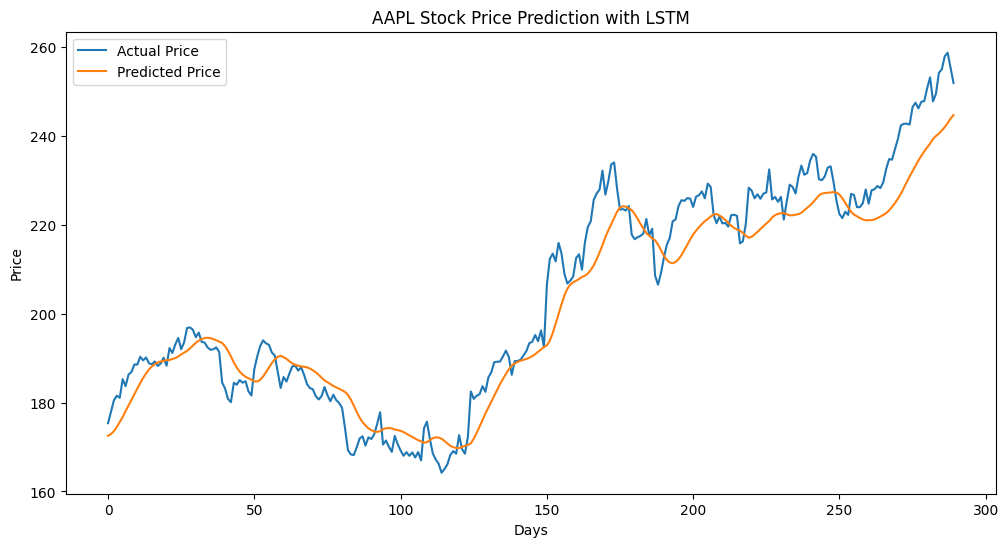

In [15]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title(f"{ticker} Stock Price Prediction with LSTM")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()


# 10. Anomaly Detection from Forecast Error

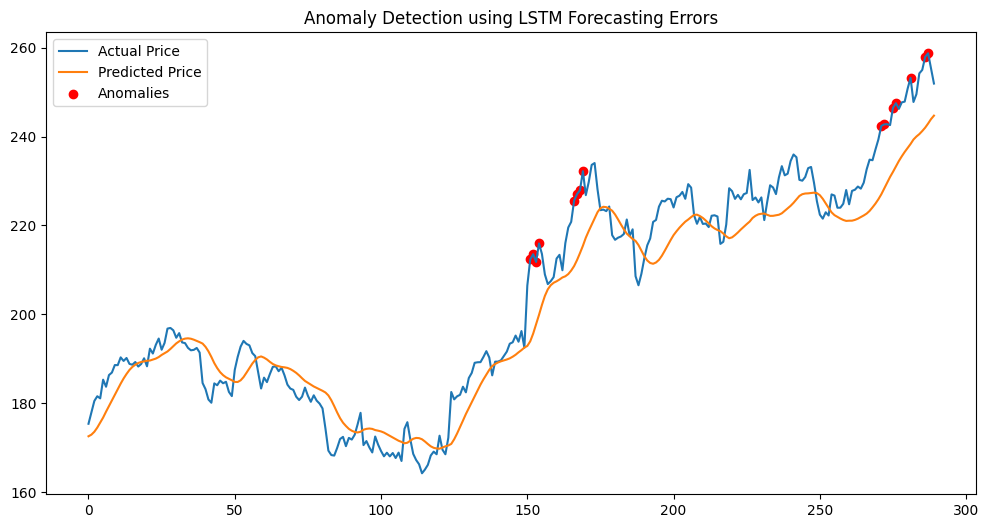

In [16]:
error = np.abs(y_test_actual.flatten() - predictions.flatten())
threshold = np.percentile(error, 95)  # top 5% as anomalies
anomalies = error > threshold

# Plot with anomalies highlighted
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.scatter(np.where(anomalies)[0], y_test_actual[anomalies], color='red', label='Anomalies')
plt.title(f"Anomaly Detection using LSTM Forecasting Errors")
plt.legend()
plt.show()


# Financial Indicators + Anomaly Detection Using Isolation Forest

[*********************100%***********************]  1 of 1 completed


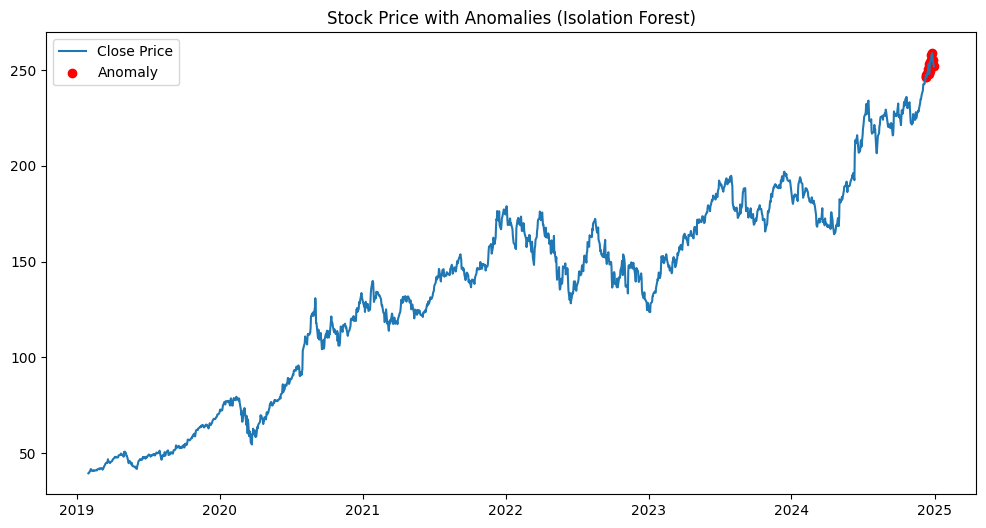

In [23]:
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Load data
df = yf.download('AAPL', start='2019-01-01', end='2024-12-31')
df = df[['Close']].copy()

# --- Financial Indicators ---
# Simple Moving Average (SMA)
df['SMA_20'] = df['Close'].rolling(window=20).mean()

# Exponential Moving Average (EMA)
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

# Relative Strength Index (RSI)
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Bollinger Bands
rolling_mean = df['Close'].rolling(window=20).mean()
rolling_std = df['Close'].rolling(window=20).std()
df['BB_Upper'] = rolling_mean + 2 * rolling_std
df['BB_Lower'] = rolling_mean - 2 * rolling_std

# Drop rows with any NaNs due to rolling/EMA/RSI
df.dropna(inplace=True)

# --- Features for Anomaly Detection ---
features = df[['Close', 'SMA_20', 'EMA_20', 'RSI', 'BB_Upper', 'BB_Lower']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# --- Fit Isolation Forest ---
isof = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df['anomaly'] = isof.fit_predict(scaled_features)
df['anomaly'] = df['anomaly'].apply(lambda x: 1 if x == -1 else 0)

# --- Plot ---
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Close Price')
plt.scatter(df[df['anomaly'] == 1].index, df[df['anomaly'] == 1]['Close'], color='red', label='Anomaly')
plt.title("Stock Price with Anomalies (Isolation Forest)")
plt.legend()
plt.show()


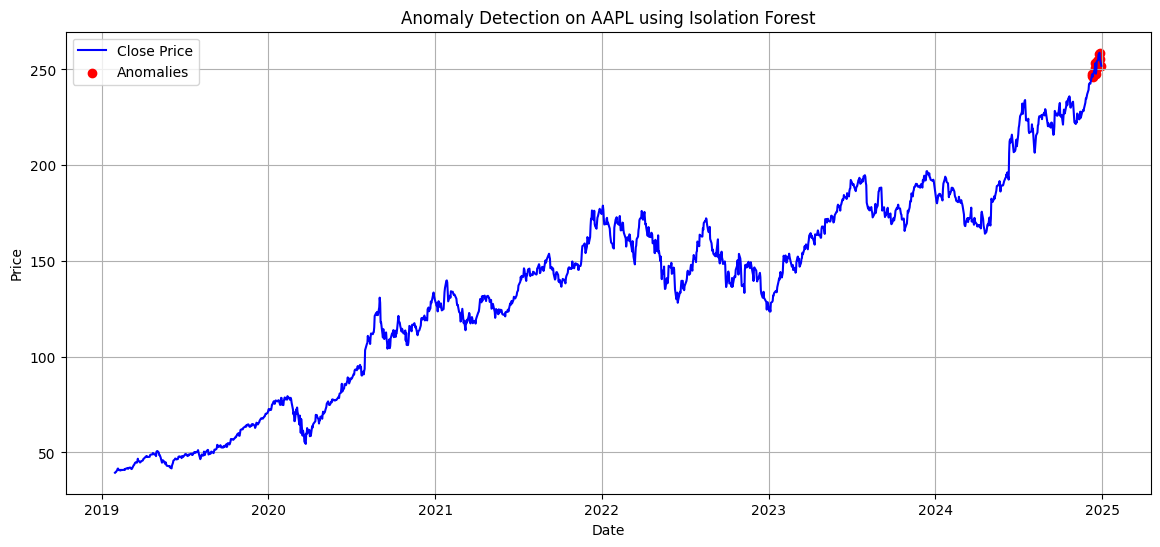

In [24]:
plt.figure(figsize=(14,6))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.scatter(df[df['anomaly'] == 1].index, df[df['anomaly'] == 1]['Close'], color='red', label='Anomalies')
plt.title(f"Anomaly Detection on {ticker} using Isolation Forest")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
